### | 33.12 | 92.67 |


In [ ]:
!pip list | grep torch
%cd /content/drive/MyDrive/ 
%ls
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111
/content/drive/MyDrive
 cimg.rar            img.rar         label.rar
 cmask.rar           Iono2630_npy@   mmsegmentation/
'Colab Notebooks'/   Iono4311.rar    mmsegmentation17/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 68.5 MB 8.4 MB/s 
     |████████████████████████████████| 190 kB 5.2 MB/s 


In [ ]:
%cd mmsegmentation

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image

/content/drive/MyDrive/mmsegmentation
1.10.0+cu111 True
0.20.2


In [ ]:
data_root = 'Iono4311'
img_dir = 'cimg'
ann_dir = 'cmask'
split_dir = 'splits'
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
# 定义数据集类型，指定类名称，调色板，后缀等 打开你文件后第二次执行需要注释以下内容

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [ ]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Class Balanced Loss & Multiple Losses
cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.15, 1.4, 4, 6, 2, 1, 20])
cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.15, 1.4, 4, 6, 2, 1, 20])
# cfg.model.decode_head.loss_decode = dict(type='LovaszLoss', reduction='none')
# cfg.model.auxiliary_head.loss_decode = dict(type='LovaszLoss', reduction='none', loss_weight=0.4)

## Online Hard Example Mining
# cfg.model.decode_head.sampler=dict(type='OHEMPixelSampler', thresh=0.75, min_kept=100000)
# cfg.model.auxiliary_head.sampler=dict(type='OHEMPixelSampler', thresh=0.75, min_kept=100000)

cfg.optimizer = dict(type='SGD', lr=0.0002, momentum=0.9, weight_decay=0.0005)    
# cfg.optimizer = dict(type='Adam', lr=0.001, betas=(0.9, 0.999), eps=1e-08)    

cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)

## Different Learning Rate(LR) for Backbone and Heads
# cfg.optimizer.paramwise_cfg.custom_keys={'head': dict(lr_mult=10.)}

## modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 7
cfg.model.auxiliary_head.num_classes = 7

# Modify dataset type and path
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8 

cfg.img_norm_cfg = dict(
    mean=[5.45, 5.45, 5.45], std=[13.12, 13.12, 13.12],  to_rgb=False)
cfg.crop_size = (512, 512)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomFlip', flip_ratio=0),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
      img_scale=(360, 400), # image scale
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75], # 多尺度测试
        flip=False, # 图像翻转
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

cfg.load_from = 'work_dirs/ckpt/iou_3589_acc_9352.pth'

# Set up working dir to save files and logs. 保存模型
cfg.work_dir = './work_dirs/pspnet'

cfg.runner.max_iters = 431*10     # 迭代次数不能太小，否则推理会报错【ValueError】
cfg.log_config.interval = 100       # 每10次迭代打印一行log
cfg.evaluation.interval = 431     # 如果evaluation和ckpt都没有，会报错【pad】
cfg.checkpoint_config.interval = 431 #

cfg.checkpoint_config.meta = dict(
    CLASSES=classes,
    PALETTE=palette)

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1) 

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')
Config.dump(cfg, './work_dirs/pspnet/pspnet_ce.py')

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALLETTE = datasets[0].PALETTE
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-02-16 16:20:15,037 - mmseg - INFO - Loaded 3448 images
/content/drive/MyDrive/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-16 16:20:27,950 - mmseg - INFO - Loaded 863 images
2022-02-16 16:20:27,956 - mmseg - INFO - load checkpoint from local path: work_dirs/ckpt/iou_3589_acc_9352.pth
2022-02-16 16:20:33,923 - mmseg - INFO - Start running, host: root@c8b38dc48cc7,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 863/863, 3.0 task/s, elapsed: 289s, ETA:     0s

2022-02-16 16:45:19,212 - mmseg - INFO - per class results:
2022-02-16 16:45:19,215 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  99.6 | 99.63 |
|     E      | 30.72 | 88.15 |
|    Es-l    | 34.94 | 93.68 |
|    Es-c    | 22.67 | 93.46 |
|     F1     | 37.12 |  84.3 |
|     F2     | 49.97 | 91.45 |
|  Spread F  | 22.75 | 77.78 |
+------------+-------+-------+
2022-02-16 16:45:19,217 - mmseg - INFO - Summary:
2022-02-16 16:45:19,218 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.59 | 42.54 | 89.78 |
+-------+-------+-------+
2022-02-16 16:45:19,224 - mmseg - INFO - Iter(val) [863]	aAcc: 0.9959, mIoU: 0.4254, mAcc: 0.8978, IoU.Background: 0.9960, IoU.E: 0.3072, IoU.Es-l: 0.3494, IoU.Es-c: 0.2267, IoU.F1: 0.3712, IoU.F2: 0.4997, IoU.Spread F: 0.2275, Acc.Background: 0.9963, Acc.E: 0.8815, Acc.Es-l: 0.9368, Acc.Es-c: 0.9346, Acc.F1: 0.8430, Acc.F2: 0.9145, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 863/863, 11.1 task/s, elapsed: 78s, ETA:     0s

2022-02-16 17:05:33,560 - mmseg - INFO - per class results:
2022-02-16 17:05:33,561 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 99.59 | 99.62 |
|     E      | 31.05 | 87.16 |
|    Es-l    | 31.59 | 95.46 |
|    Es-c    | 20.85 | 95.21 |
|     F1     | 37.07 |  85.7 |
|     F2     | 50.39 | 91.86 |
|  Spread F  |  21.6 | 79.39 |
+------------+-------+-------+
2022-02-16 17:05:33,564 - mmseg - INFO - Summary:
2022-02-16 17:05:33,570 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.59 | 41.74 | 90.63 |
+-------+-------+-------+
2022-02-16 17:05:33,572 - mmseg - INFO - Iter(val) [863]	aAcc: 0.9959, mIoU: 0.4174, mAcc: 0.9063, IoU.Background: 0.9959, IoU.E: 0.3105, IoU.Es-l: 0.3159, IoU.Es-c: 0.2085, IoU.F1: 0.3707, IoU.F2: 0.5039, IoU.Spread F: 0.2160, Acc.Background: 0.9962, Acc.E: 0.8716, Acc.Es-l: 0.9546, Acc.Es-c: 0.9521, Acc.F1: 0.8570, Acc.F2: 0.9186, 

KeyboardInterrupt: ignored

/content/drive/MyDrive/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x288 with 0 Axes>

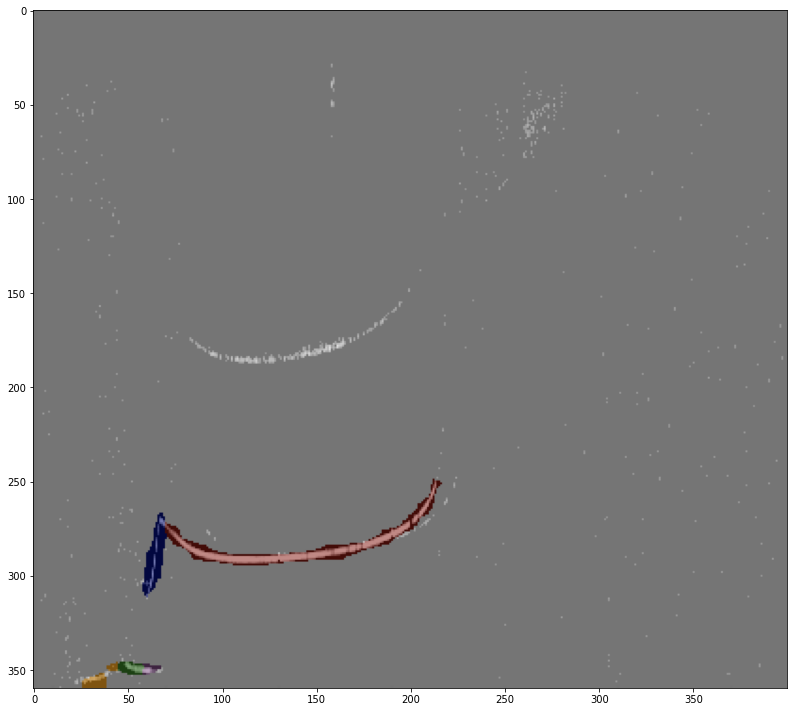

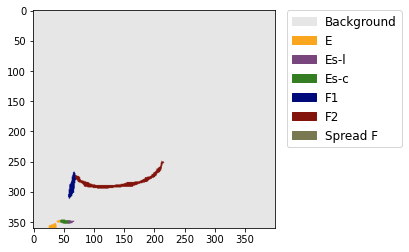

In [ ]:

img = mmcv.imread('Iono4311/cimg/20191106131500.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 4))

show_result_pyplot(model, img, result, palette)

# 画出legend
seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
# plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(seg_res.convert('RGB')))
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.show()
